# Sentimental Analysis

In [ ]:
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import re
import numpy as np
import re
import nltk
nltk.download('punkt')  
from nltk.tokenize import sent_tokenize
from scipy.stats import ttest_ind
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from transformers import BertTokenizerFast, BertModel, BertPreTrainedModel
from transformers import Trainer, TrainingArguments
from transformers.modeling_outputs import SequenceClassifierOutput
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import os
import shap
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer
from scipy.stats import spearmanr


In [ ]:
pip install transformers torch tqdm
pip install transformers datasets scikit-learn torch
pip install -U accelerate
pip install transformers[torch]
!pip install shap
!pip install lime

In [ ]:

file_path = r"C:\Users\KS\Downloads\archive\salary_data_cleaned_excel_ready.csv"

df = pd.read_csv(file_path, sep=';', encoding='utf-8')

print(df.columns)
print(df.head())

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
       'company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'R_yn',
       'spark', 'aws', 'excel'],
      dtype='object')
                   Job Title              Salary Estimate  \
0             Data Scientist   $53K-$91K (Glassdoor est.)   
1  Healthcare Data Scientist  $63K-$112K (Glassdoor est.)   
2             Data Scientist   $80K-$90K (Glassdoor est.)   
3             Data Scientist   $56K-$97K (Glassdoor est.)   
4             Data Scientist  $86K-$143K (Glassdoor est.)   

                                     Job Description  Rating  \
0  Data Scientist\nLocation: Albuquerque, NM\nEdu...     3.8   
1  What You Will Do:\n\nI. General Summary\n\nThe...     3.4   
2  KnowBe4, Inc

In [3]:
print(df.dtypes)

print(f"Liczba kolumn: {len(df.columns)}")
print(df.columns.tolist())

print(df['Job Description'].head(3))

missing_desc = df['Job Description'].isna().sum()
print(f"\n🔎 empty job ads: {missing_desc}")

Job Title             object
Salary Estimate       object
Job Description       object
Rating               float64
Company Name          object
Location              object
Headquarters          object
Size                  object
Founded                int64
Type of ownership     object
Industry              object
Sector                object
Revenue               object
Competitors           object
hourly                 int64
employer_provided      int64
min_salary             int64
max_salary             int64
avg_salary           float64
company_txt           object
job_state             object
same_state             int64
age                    int64
python_yn              int64
R_yn                   int64
spark                  int64
aws                    int64
excel                  int64
dtype: object
Liczba kolumn: 28
['Job Title', 'Salary Estimate', 'Job Description', 'Rating', 'Company Name', 'Location', 'Headquarters', 'Size', 'Founded', 'Type of ownership', 'Industry'

## 1. Data preparation

In [ ]:
#Define a function to extract the average salary from a salary range string
def extract_salary_mean(salary_str):
    clean = re.sub(r'[^\d\-]', '', str(salary_str))
    
   # If it's a range like "50000-70000", calculate the mean
    if '-' in clean:
        parts = clean.split('-')
        if len(parts) == 2:
            try:
                low = int(parts[0])
                high = int(parts[1])
                return (low + high) / 2
            except ValueError:
                return np.nan
    return np.nan 


df['Salary_Avg'] = df['Salary Estimate'].apply(extract_salary_mean)


print(df[['Salary Estimate', 'Salary_Avg']].head(10))

df['Salary_Avg'] = df['Salary Estimate'].apply(extract_salary_mean)

df_1 = df[['Salary_Avg', 'Rating', 'Job Description']]

print(df_1.head())
print(df_1[['Job Description']].head(10))

# Function to clean text in job descriptions

def clean_text(text):
    if pd.isnull(text):
        return ""
    
    text = text.replace('\n', ' ').replace('\r', ' ')
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9.,!?\' ]', '', text)

    return text.strip()

#  Apply text cleaning to all job descriptions

df_1['Cleaned_Description'] = df_1['Job Description'].apply(clean_text)

def first_n_sentences(text, n=3):
    sentences = sent_tokenize(text)
    return " ".join(sentences[:n])

#  Add a column with only the first 3 sentences from each description to Improve firther Model Performance adn Prepare for Embeddings or NLP Tasks
df_1['Short_Cleaned_Description'] = df_1['Cleaned_Description'].apply(lambda x: first_n_sentences(x, n=3))

print(df_1[['Job Description', 'Cleaned_Description', 'Short_Cleaned_Description']].head(3))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                Salary Estimate  Salary_Avg
0    $53K-$91K (Glassdoor est.)        72.0
1   $63K-$112K (Glassdoor est.)        87.5
2    $80K-$90K (Glassdoor est.)        85.0
3    $56K-$97K (Glassdoor est.)        76.5
4   $86K-$143K (Glassdoor est.)       114.5
5   $71K-$119K (Glassdoor est.)        95.0
6    $54K-$93K (Glassdoor est.)        73.5
7   $86K-$142K (Glassdoor est.)       114.0
8    $38K-$84K (Glassdoor est.)        61.0
9  $120K-$160K (Glassdoor est.)       140.0
   Salary_Avg  Rating                                    Job Description
0        72.0     3.8  Data Scientist\nLocation: Albuquerque, NM\nEdu...
1        87.5     3.4  What You Will Do:\n\nI. General Summary\n\nThe...
2        85.0     4.8  KnowBe4, Inc. is a high growth information sec...
3        76.5     3.8  *Organization and Job ID**\nJob ID: 310709\n\n...
4       114.5     2.9  Data Scientist\nAffinity Solutions / Marketing...
                                     Job Description
0  Data Scientist\nLocati


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                                     Job Description  \
0  Data Scientist\nLocation: Albuquerque, NM\nEdu...   
1  What You Will Do:\n\nI. General Summary\n\nThe...   
2  KnowBe4, Inc. is a high growth information sec...   

                                 Cleaned_Description  \
0  Data Scientist Location Albuquerque, NM Educat...   
1  What You Will Do I. General Summary The Health...   
2  KnowBe4, Inc. is a high growth information sec...   

                           Short_Cleaned_Description  
0  Data Scientist Location Albuquerque, NM Educat...  
1  What You Will Do I. General Summary The Health...  
2  KnowBe4, Inc. is a high growth information sec...  



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## 2. Attempting to split the data

In [6]:
# Define a function to classify job descriptions into experience levels
def classify_experience(text):
    text = text.lower() # Convert text to lowercase to make keyword matching case-insensitive
    

    junior_keywords = ['entry level', 'junior', 'graduate', 'new grad', 'no experience', '0-1 years', '1+ years', '1 year experience']

    senior_keywords = ['senior', 'lead', '5+ years', '7+ years', 'manager', 'director', '10+ years', 'extensive experience', '5 years experience']

    junior = any(kw in text for kw in junior_keywords)
    senior = any(kw in text for kw in senior_keywords)

    if junior and not senior:   # Classify based on presence of keywords
        return 'Junior'     # Only junior terms found
    elif senior and not junior:
        return 'Senior'     # Only senior terms found
    elif junior and senior:
        return 'Mixed'   # Both junior and senior terms found
    else:
        return 'Unclear' # No clear match
 #  Apply the classification function to each cleaned job description       
df_1['Experience_Level'] = df_1['Cleaned_Description'].apply(classify_experience)
print(df_1['Experience_Level'].value_counts())

Senior     486
Unclear    145
Mixed       84
Junior      27
Name: Experience_Level, dtype: int64



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
def map_experience_group(level):   # Define a function to group experience levels into broader categories
    if level in ['Junior', 'Unclear']:
        return 'Less Experienced'      # Group 'Junior' and 'Unclear' into 'Less Experienced'
    elif level in ['Senior', 'Mixed']:
        return 'More Experienced'     # Group 'Senior' and 'Mixed' into 'More Experienced'
    else:
        return 'Unknown' 
    
df_1['Experience_Grouped'] = df_1['Experience_Level'].apply(map_experience_group)   # Apply the grouping function to the 'Experience_Level' column

print("n:")
print(df_1['Experience_Grouped'].value_counts())

print("\n avg salary:")
print(df_1.groupby('Experience_Grouped')['Salary_Avg'].mean())

n:
More Experienced    570
Less Experienced    172
Name: Experience_Grouped, dtype: int64

 avg salary:
Experience_Grouped
Less Experienced     92.918605
More Experienced    102.951754
Name: Salary_Avg, dtype: float64



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:

less_exp_salaries = df_1[df_1['Experience_Grouped'] == 'Less Experienced']['Salary_Avg'].dropna()
more_exp_salaries = df_1[df_1['Experience_Grouped'] == 'More Experienced']['Salary_Avg'].dropna()

t_stat, p_val = ttest_ind(more_exp_salaries, less_exp_salaries, equal_var=False)

print("T-statistic:", t_stat)
print("p-value:", p_val)

if p_val < 0.05:
    print("✅ (p < 0.05).")
else:
    print("❌ (p ≥ 0.05).")

T-statistic: 3.0586556251016406
p-value: 0.002428637938888729
✅ (p < 0.05).


## Preparing ML model

In [ ]:

#  Select features and drop rows with missing values
X = df_1[['Salary_Avg', 'Rating']].dropna()

#  Define target variable: map experience level to binary values
y = df_1.loc[X.index, 'Experience_Grouped'].map({'Less Experienced': 0, 'More Experienced': 1})

#  Balance the dataset (undersample the majority class)
df_bal = X.copy()
df_bal['y'] = y
min_class_size = df_bal['y'].value_counts().min()  # Find size of the smaller class
df_balanced = df_bal.groupby('y').apply(lambda x: x.sample(min_class_size, random_state=42)).reset_index(drop=True)

#  Redefine X and y using the balanced dataset
X = df_balanced[['Salary_Avg', 'Rating']]
y = df_balanced['y']

#  Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#  Train the Random Forest Classifier
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

#  Make predictions on the test set
y_pred = model_rf.predict(X_test)

#  Evaluate model performance
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Less Experienced", "More Experienced"]))
print("📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#  Show 10 example predictions
df_results = X_test.copy()
df_results['Predicted'] = y_pred
df_results['Actual'] = y_test.values
df_results['Predicted_Label'] = df_results['Predicted'].map({0: 'Less Experienced', 1: 'More Experienced'})
df_results['Actual_Label'] = df_results['Actual'].map({0: 'Less Experienced', 1: 'More Experienced'})

print("\n🔍 10 sample prediction results:")
print(df_results[['Salary_Avg', 'Rating', 'Actual_Label', 'Predicted_Label']].head(10))

📊 Classification Report:
                  precision    recall  f1-score   support

Less Experienced       0.72      0.69      0.70        55
More Experienced       0.67      0.69      0.68        49

        accuracy                           0.69       104
       macro avg       0.69      0.69      0.69       104
    weighted avg       0.69      0.69      0.69       104

📉 Confusion Matrix:
[[38 17]
 [15 34]]

🔍 10 sample prediction results:
     Salary_Avg  Rating      Actual_Label   Predicted_Label
194        54.0     3.7  More Experienced  More Experienced
157        87.0     3.7  Less Experienced  Less Experienced
225        72.5     4.3  More Experienced  Less Experienced
208       146.0     3.6  More Experienced  More Experienced
318       124.0     2.6  More Experienced  Less Experienced
329        49.0     3.9  More Experienced  Less Experienced
319        69.5     3.7  More Experienced  More Experienced
260        48.5     3.6  More Experienced  Less Experienced
114        5

In [ ]:

# Load and clean dataset
df = df_1[['Short_Cleaned_Description', 'Experience_Grouped', 'Salary_Avg', 'Rating']].dropna()

# Convert target labels to numeric
df['label'] = df['Experience_Grouped'].map({'Less Experienced': 0, 'More Experienced': 1})

# Initialize BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Scale numerical features (Salary and Rating)
scaler = StandardScaler()
X_extra = scaler.fit_transform(df[['Salary_Avg', 'Rating']])

# Custom dataset class combining text and extra numeric features
class BertWithExtraFeaturesDataset(Dataset):
    def __init__(self, texts, labels, extra_features):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
        self.labels = labels
        self.extra_features = extra_features

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['extra_features'] = torch.tensor(self.extra_features[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

# Split text, extra features and labels into train and test sets
X_train_text, X_test_text, X_train_extra, X_test_extra, y_train, y_test = train_test_split(
    df['Short_Cleaned_Description'], X_extra, df['label'], test_size=0.2, random_state=42
)

# Create PyTorch-compatible datasets
train_dataset = BertWithExtraFeaturesDataset(X_train_text.tolist(), y_train.tolist(), X_train_extra)
test_dataset = BertWithExtraFeaturesDataset(X_test_text.tolist(), y_test.tolist(), X_test_extra)

# Define BERT model extended with extra features (Salary_Avg, Rating)
class BertWithExtraFeatures(BertPreTrainedModel):
    def __init__(self, config, extra_feature_dim=2):
        super().__init__(config)
        self.bert = BertModel(config)
        self.extra_layer = nn.Linear(extra_feature_dim, 16)  # process numeric features
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size + 16, config.num_labels)  # concat BERT + extras

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                labels=None, extra_features=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs.pooler_output
        extra_out = torch.relu(self.extra_layer(extra_features))
        combined = torch.cat((pooled_output, extra_out), dim=1)
        combined = self.dropout(combined)
        logits = self.classifier(combined)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return SequenceClassifierOutput(loss=loss, logits=logits)

# Load BERT configuration and instantiate the model
from transformers import BertConfig
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=2)
model = BertWithExtraFeatures.from_pretrained("bert-base-uncased", config=config)

# Define training configuration
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="no",
)

# Custom collate function to handle extra_features during batching
def collate_fn(batch):
    keys = batch[0].keys()
    return {
        key: torch.stack([b[key] for b in batch]) if key != 'extra_features' else torch.stack([b[key] for b in batch])
        for key in keys
    }

# Set up Trainer with datasets, model and training arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=collate_fn
)

# Train the model
trainer.train()

# Evaluate model on test data
preds = trainer.predict(test_dataset)
y_pred = preds.predictions.argmax(axis=1)

# Show classification results
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Less Experienced", "More Experienced"]))

Some weights of BertWithExtraFeatures were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'extra_layer.bias', 'extra_layer.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.


  0%|          | 0/114 [00:00<?, ?it/s]

{'loss': 0.5782, 'grad_norm': 3.4078640937805176, 'learning_rate': 4.56140350877193e-05, 'epoch': 0.26}
{'loss': 0.524, 'grad_norm': 4.02264928817749, 'learning_rate': 4.12280701754386e-05, 'epoch': 0.53}
{'loss': 0.5874, 'grad_norm': 1.9178650379180908, 'learning_rate': 3.6842105263157895e-05, 'epoch': 0.79}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.4993763267993927, 'eval_runtime': 54.0306, 'eval_samples_per_second': 2.758, 'eval_steps_per_second': 0.185, 'epoch': 1.0}
{'loss': 0.5095, 'grad_norm': 1.7252320051193237, 'learning_rate': 3.24561403508772e-05, 'epoch': 1.05}
{'loss': 0.5134, 'grad_norm': 3.705643653869629, 'learning_rate': 2.8070175438596492e-05, 'epoch': 1.32}
{'loss': 0.4974, 'grad_norm': 3.2107698917388916, 'learning_rate': 2.368421052631579e-05, 'epoch': 1.58}
{'loss': 0.4413, 'grad_norm': 4.119200229644775, 'learning_rate': 1.929824561403509e-05, 'epoch': 1.84}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.4346112608909607, 'eval_runtime': 49.9428, 'eval_samples_per_second': 2.983, 'eval_steps_per_second': 0.2, 'epoch': 2.0}
{'loss': 0.3802, 'grad_norm': 3.6641416549682617, 'learning_rate': 1.4912280701754386e-05, 'epoch': 2.11}
{'loss': 0.2346, 'grad_norm': 12.628549575805664, 'learning_rate': 1.0526315789473684e-05, 'epoch': 2.37}
{'loss': 0.3151, 'grad_norm': 4.7740397453308105, 'learning_rate': 6.140350877192982e-06, 'epoch': 2.63}
{'loss': 0.3597, 'grad_norm': 16.610326766967773, 'learning_rate': 1.7543859649122807e-06, 'epoch': 2.89}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.4124520421028137, 'eval_runtime': 39.7428, 'eval_samples_per_second': 3.749, 'eval_steps_per_second': 0.252, 'epoch': 3.0}
{'train_runtime': 1970.1186, 'train_samples_per_second': 0.903, 'train_steps_per_second': 0.058, 'train_loss': 0.44161813091813473, 'epoch': 3.0}


  0%|          | 0/10 [00:00<?, ?it/s]


📊 Classification Report:
                  precision    recall  f1-score   support

Less Experienced       0.67      0.40      0.50        30
More Experienced       0.86      0.95      0.90       119

        accuracy                           0.84       149
       macro avg       0.76      0.67      0.70       149
    weighted avg       0.82      0.84      0.82       149



In [18]:
torch.save(model.extra_layer.state_dict(), "extra_layer_weights.pt")
torch.save(model.classifier.state_dict(), "classifier_weights.pt")

In [87]:

class ExtraFeatureOnlyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.extra_layer = nn.Linear(2, 16)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(768 + 16, 2)
        self.dummy_bert = torch.zeros(1, 768)

    def forward(self, x_extra):
        batch_size = x_extra.size(0)
        extra_out = self.relu(self.extra_layer(x_extra))
        dummy_out = self.dummy_bert.repeat(batch_size, 1)
        combined = torch.cat([dummy_out, extra_out], dim=1)
        logits = self.classifier(combined)
        return torch.softmax(logits, dim=1)

# Instantiate the model
light_model = ExtraFeatureOnlyModel()

# Load weights from disk
light_model.extra_layer.load_state_dict(torch.load("extra_layer_weights.pt"))
light_model.classifier.load_state_dict(torch.load("classifier_weights.pt"))

# Set to evaluation mode
light_model.eval()

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possibl

ExtraFeatureOnlyModel(
  (extra_layer): Linear(in_features=2, out_features=16, bias=True)
  (relu): ReLU()
  (classifier): Linear(in_features=784, out_features=2, bias=True)
)

### Metrics 

## 1/5 MEMC

SHAP explains which features the model uses most for its prediction.
MEMC checks how much the model's performance depends on those top features.

METRICS FOR RANDOM FOREST (model_rf)

✅ RF AUC: 0.745
✅ RF MEMC: 0.1797
ΔAUC (top-1, top-2): [0.11428571428571432, 0.24508348794063084]


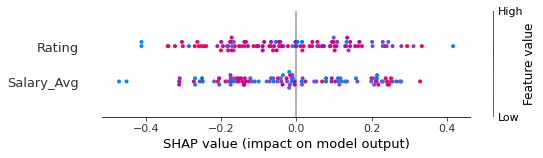

In [ ]:
# Disable GPU usage (prevent unnecessary memory pressure)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

print( "METRICS FOR RANDOM FOREST (model_rf)")

# Initialize SHAP TreeExplainer (optimized for tree-based models)
explainer_rf = shap.TreeExplainer(model_rf)

# Compute SHAP values for class 1 (More Experienced)
shap_values_rf = explainer_rf.shap_values(X_test)[1]

# Rank features by average absolute SHAP value
mean_abs_shap = np.abs(shap_values_rf).mean(axis=0)
ranked_idx = np.argsort(-mean_abs_shap)

# Get original predictions and AUC using all features
y_pred_orig = model_rf.predict_proba(X_test)[:, 1]
auc_orig = roc_auc_score(y_test, y_pred_orig)

# Compute AUC drops after zeroing out top-1 and top-2 SHAP features
drops = []
for k in [1, 2]:
    X_mut = X_test.copy()
    for i in range(k):
        col = X_test.columns[ranked_idx[i]]
        X_mut[col] = 0
    y_pred_mut = model_rf.predict_proba(X_mut)[:, 1]
    auc_mut = roc_auc_score(y_test, y_pred_mut)
    drops.append(auc_orig - auc_mut)

# Calculate Mean Excluded Marginal Contribution (MEMC)
memc_rf = np.mean(drops)

# Print results
print(f"\n RF AUC: {auc_orig:.3f}")
print(f" RF MEMC: {memc_rf:.4f}")
print("ΔAUC (top-1, top-2):", drops)

shap.summary_plot(shap_values_rf, features=X_test, feature_names=X_test.columns)

Metrics:

AUC 0.745 - Good ability to distinguish between classes.
MEMC = 0.1797 - Removing top-1 and top-2 features causes notable performance drops, showing strong reliance on key features.

ΔAUC: [0.11, 0.24] - Especially the 2nd most important feature has a major influence.

SHAP plot: Shows that both Salary_Avg and Rating have a modest but consistent impact.

🤖 SHAP & MEMC for Light BERT Model (only Salary/Rating)


  0%|          | 0/50 [00:00<?, ?it/s]

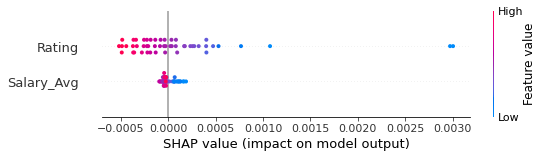


✅ Light BERT AUC: 0.522
✅ Light BERT MEMC: 0.0216
ΔAUC after removing top-1 and top-2 SHAP features: [0.021008403361344574, 0.022268907563025242]


In [ ]:
print(" SHAP & MEMC for Light BERT Model (only Salary/Rating)")

# Recreate test features (X_test_extra) after restart ===
# Make sure 'df_1' and 'y_test' still exist in memory
df = df_1[['Salary_Avg', 'Rating', 'Experience_Grouped']].dropna()
df['label'] = df['Experience_Grouped'].map({'Less Experienced': 0, 'More Experienced': 1})

# Rescale Salary_Avg and Rating
scaler = StandardScaler()
X_extra = scaler.fit_transform(df[['Salary_Avg', 'Rating']])

# Re-split into train/test 
from sklearn.model_selection import train_test_split
_, X_test_extra, _, y_test = train_test_split(
    X_extra, df['label'], test_size=0.2, random_state=42
)

# Define light BERT prediction function
def predict_light_model(X_np):
    with torch.no_grad():
        x_tensor = torch.tensor(X_np, dtype=torch.float)
        return light_model(x_tensor).numpy()

# Run SHAP analysis 
background_sample = shap.sample(X_test_extra, 100, random_state=42)
explainer = shap.KernelExplainer(predict_light_model, background_sample)

shap_values = explainer.shap_values(X_test_extra[:50])
shap.summary_plot(shap_values, features=X_test_extra[:50], feature_names=["Salary_Avg", "Rating"])

# MEMC computation
def compute_memc_light(predict_fn, X, y, shap_vals):
    mean_abs_shap = np.abs(shap_vals).mean(axis=0)
    ranked_idx = np.argsort(-mean_abs_shap)

    y_pred_orig = predict_fn(X)
    auc_orig = roc_auc_score(y, y_pred_orig)

    drops = []
    for k in [1, 2]:
        X_mut = X.copy()
        for i in range(k):
            X_mut[:, ranked_idx[i]] = 0
        y_mut = predict_fn(X_mut)
        auc_mut = roc_auc_score(y, y_mut)
        drops.append(auc_orig - auc_mut)

    return np.mean(drops), drops, auc_orig

memc, drops, auc = compute_memc_light(predict_light_model, X_test_extra, y_test.values, shap_values)
print(f"\n Light BERT AUC: {auc:.3f}")
print(f" Light BERT MEMC: {memc:.4f}")
print("ΔAUC after removing top-1 and top-2 SHAP features:", drops)

Metrics:
AUC = 0.522 - Near-random guessing (no meaningful signal captured).
MEMC = 0.0216 - Removing top features barely changes the output. Weak explanatory power of the model.

ΔAUC: [0.021, 0.022] → Marginal performance drop.Plot - SHAP values are more negative, meaning the model slightly favors predicting "Less Experienced" based on Salary_Avg and Rating

Random Forest clearly outperforms the Light BERT model trained on Salary_Avg and Rating alone.

It detects useful patterns and relies strongly on the top features.

The Light BERT model likely suffers because it doesn’t use the BERT text embedding at all, only a small extra layer — hence, it performs like a weak linear model on two scaled variables

## 2/5 AUPRC Top-k Feature Selection

Trains a separate model using only the top 1 or 2 most important features (based on SHAP).
Measures how much predictive power they carry on their own, via AUPRC.
Useful for testing SHAP precision — if top features lead to high AUPRC, SHAP ranking is effective.

In [ ]:
# Set environment to avoid GPU issues
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# STEP 1: Prepare the data
X = df_1[['Salary_Avg', 'Rating']].dropna()
y = df_1.loc[X.index, 'Experience_Grouped'].map({'Less Experienced': 0, 'More Experienced': 1})

# Balance the dataset
df_bal = X.copy()
df_bal['y'] = y
min_class_size = df_bal['y'].value_counts().min()
df_balanced = df_bal.groupby('y').apply(lambda x: x.sample(min_class_size, random_state=42)).reset_index(drop=True)

# Redefine X and y from balanced set
X = df_balanced[['Salary_Avg', 'Rating']]
y = df_balanced['y']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# STEP 2: Train main RF model
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

# STEP 3: Compute SHAP values on training data
explainer_rf = shap.TreeExplainer(model_rf)
shap_values_rf_train = explainer_rf.shap_values(X_train)[1]  # Use class 1 SHAP values

# STEP 4: Define AUPRC top-k metric function
def compute_auprc_topk_rf(X_train, y_train, X_test, y_test, shap_values_train, k):
    # Rank features by mean SHAP value
    mean_abs_shap = np.abs(shap_values_train).mean(axis=0)
    ranked_idx = np.argsort(-mean_abs_shap)
    topk_features = X_train.columns[ranked_idx[:k]]

    # Select top-k features
    X_train_topk = X_train[topk_features]
    X_test_topk = X_test[topk_features]

    # Train new RF model
    model_topk = RandomForestClassifier(random_state=42)
    model_topk.fit(X_train_topk, y_train)

    # Predict probabilities
    y_proba = model_topk.predict_proba(X_test_topk)[:, 1]

    # Compute AUPRC
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auprc = auc(recall, precision)

    return auprc

# STEP 5: Evaluate AUPRC for top-1 and top-2 SHAP features
auprc_k1 = compute_auprc_topk_rf(X_train, y_train, X_test, y_test, shap_values_rf_train, k=1)
auprc_k2 = compute_auprc_topk_rf(X_train, y_train, X_test, y_test, shap_values_rf_train, k=2)

# STEP 6: Output results
print(f" AUPRC (Top-1 SHAP feature): {auprc_k1:.3f}")
print(f" AUPRC (Top-2 SHAP features): {auprc_k2:.3f}")

✅ AUPRC (Top-1 SHAP feature): 0.651
✅ AUPRC (Top-2 SHAP features): 0.684


The top-1 feature alone explains 65% of the area under the precision-recall curve — already strong.
Adding the second top feature improves performance only slightly (+3%), reaching 68% AUPRC. So SHAP’s feature ranking appears trustworthy in this context.

In [ ]:
# ensure predict_light_model and light_model are already defined and loaded 

# Prepare data
# Recreate X_test_extra and y_test (already standardized and split before)
df = df_1[['Salary_Avg', 'Rating', 'Experience_Grouped']].dropna()
df['label'] = df['Experience_Grouped'].map({'Less Experienced': 0, 'More Experienced': 1})

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_extra = scaler.fit_transform(df[['Salary_Avg', 'Rating']])

from sklearn.model_selection import train_test_split
_, X_test_extra, _, y_test = train_test_split(
    X_extra, df['label'], test_size=0.2, random_state=42
)

# SHAP values on 50 samples
background_sample = shap.sample(X_test_extra, 100, random_state=42)

# Define prediction wrapper
def predict_light_model(X_np):
    with torch.no_grad():
        x_tensor = torch.tensor(X_np, dtype=torch.float)
        return light_model(x_tensor).numpy()

explainer = shap.KernelExplainer(predict_light_model, background_sample)

# Only explain 50 samples (speed optimization)
X_used = X_test_extra[:50]
y_used = y_test.values[:50]

shap_values = explainer.shap_values(X_used)

# AUPRC Top-k function
def compute_auprc_topk_light(predict_fn, X, y, shap_vals, k):
    """
    Compute AUPRC for Light BERT model using only top-k SHAP features.
    """
    # 1. Rank SHAP features by average importance
    mean_abs_shap = np.abs(shap_vals).mean(axis=0)
    ranked_idx = np.argsort(-mean_abs_shap)

    # 2. Zero out non-top-k features
    X_topk = X.copy()
    for i in range(X.shape[1]):
        if i not in ranked_idx[:k]:
            X_topk[:, i] = 0.0

    # 3. Predict
    y_proba = predict_fn(X_topk)

    # 4. Compute AUPRC
    precision, recall, _ = precision_recall_curve(y, y_proba)
    return auc(recall, precision)

# Run metric for k=1 and k=2
auprc_k1_light = compute_auprc_topk_light(predict_light_model, X_used, y_used, shap_values, k=1)
auprc_k2_light = compute_auprc_topk_light(predict_light_model, X_used, y_used, shap_values, k=2)

# Print results
print(f"✅ Light BERT AUPRC (Top-1 SHAP feature): {auprc_k1_light:.3f}")
print(f"✅ Light BERT AUPRC (Top-2 SHAP features): {auprc_k2_light:.3f}")

  0%|          | 0/50 [00:00<?, ?it/s]

✅ Light BERT AUPRC (Top-1 SHAP feature): 0.733
✅ Light BERT AUPRC (Top-2 SHAP features): 0.752


The top-1 feature alone explains 73% of the area under the precision-recall curve — already strong.
Adding the second top feature improves performance only slightly (+2%), reaching 75% AUPRC. So SHAP’s feature ranking appears trustworthy in this context.

Comparison: 
- Light BERT consistently achieves higher AUPRC for both Top-1 and Top-2 SHAP features.

- This means it makes more precise predictions at higher recall levels even when operating with fewer features.

## 3/5 Local Fidelity & LIME Agreement 

It compares SHAP and LIME explanations across 50 instances.

Uses Spearman rank correlation to see how similarly they rank feature importance.

Do SHAP and LIME agree on which features matter most?

In [ ]:
#  Prepare LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=["Less Experienced", "More Experienced"],
    mode="classification",
    discretize_continuous=True
)

# Generate LIME explanation for a sample instance
i = 0  # index of test sample
instance = X_test.iloc[i].values

exp = lime_explainer.explain_instance(
    data_row=instance,
    predict_fn=model_rf.predict_proba,
    num_features=len(X_test.columns)
)

# LIME weights vector 
lime_weights = dict(exp.as_list(label=1))
lime_vec = np.array([lime_weights.get(feat, 0.0) for feat in X_test.columns])

# SHAP values vector
shap_vec = shap_values_rf[i]

# Compute LIME Agreement
if np.std(lime_vec) == 0 or np.std(shap_vec) == 0:
    print(" Cannot compute LIME Agreement: One of the vectors is constant.")
else:
    rho, pval = spearmanr(shap_vec, lime_vec)
    print(f" LIME Agreement (Spearman): {rho:.3f} (p={pval:.4f})")

#  Compute Local Fidelity
try:
    # Use public LIME API to access perturbed data
    neighborhood = pd.DataFrame(exp.synthetic_data, columns=X_train.columns)
    true_preds = model_rf.predict_proba(neighborhood)[:, 1]
    surrogate_preds = exp.predictor(exp.synthetic_data)

    fidelity = 1 - mean_squared_error(true_preds, surrogate_preds)
    print(f" Local Fidelity: {fidelity:.4f}")
except Exception as e:
    print(" Could not compute Local Fidelity:", e)



⚠️ Cannot compute LIME Agreement: One of the vectors is constant.
⚠️ Could not compute Local Fidelity: 'Explanation' object has no attribute 'synthetic_data'


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


In [ ]:
X_sample = X_test.iloc[:50]  # Sample the first 50 rows of test data and corresponding SHAP values
shap_sample = shap_values_rf[:50]

def predict_with_feature_names(data_as_array):  # Function to adapt model prediction for LIME
    df = pd.DataFrame(data_as_array, columns=X.columns)
    return model_rf.predict_proba(df)

lime_explainer = LimeTabularExplainer(  # Initialize LIME explainer
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    mode="classification",
    discretize_continuous=True,
    random_state=42
)

spearman_scores = []  # Store Spearman correlation scores between SHAP and LIME for each instance

for i in range(len(X_sample)):
    lime_exp = lime_explainer.explain_instance(
        X_sample.iloc[i].values,
        predict_with_feature_names,
        num_features=X.shape[1]
    )

    shap_vec = shap_sample[i, :]  # Get SHAP and LIME explanations for the same instance
    lime_dict = dict(lime_exp.as_list())
    lime_vec = np.array([lime_dict.get(col, 0) for col in X.columns])   # Convert LIME dict to a vector aligned with SHAP (using all features)

    if len(np.unique(shap_vec)) <= 1 or len(np.unique(lime_vec)) <= 1:
        continue

    corr, _ = spearmanr(shap_vec, np.abs(lime_vec))
    spearman_scores.append(corr)

if spearman_scores:
    mean_corr = np.mean(spearman_scores)
    print(f" Mean rank correlation (Spearman) SHAP vs. LIME {mean_corr:.3f}")
else:
    print(" No observation had sufficient variability for correlation.")

print("SHAP vec:", shap_vec)
print("LIME vec:", lime_vec)

 No observation had sufficient variability for correlation.
SHAP vec: [0.01659278 0.04203222]
LIME vec: [0 0]


Attributes importance to at least one feature (Rating)

In [ ]:
# Inputs
X_sample_bert = X_test_extra[:50] # First 50 test instances
shap_sample_bert = shap_values  # Corresponding SHAP values
feature_names = ["Salary_Avg", "Rating"]

# LIME explainer
lime_explainer_bert = LimeTabularExplainer(
    training_data=X_test_extra,  # Background dataset for LIME
    feature_names=feature_names,
    mode="classification",
    discretize_continuous=True,
    random_state=42
)

# Define prediction wrapper for the light_mod
def predict_with_feature_names_bert(data_as_array):
    with torch.no_grad():
        data_tensor = torch.tensor(data_as_array, dtype=torch.float32)
        return light_model(data_tensor).cpu().numpy()

# Spearman correlation between SHAP and LIME (LIME Agreement)
spearman_scores_bert = []

for i in range(len(X_sample_bert)): # Generate local explanation with LIME
    lime_exp = lime_explainer_bert.explain_instance(
        X_sample_bert[i],
        predict_with_feature_names_bert,
        num_features=2  
    )

    shap_vec = shap_sample_bert[i]   # SHAP values for this instance
    lime_dict = dict(lime_exp.as_list(label=1))  # LIME weights for class 1
    lime_vec = np.array([lime_dict.get(col, 0) for col in feature_names])

    if len(np.unique(shap_vec)) <= 1 or len(np.unique(lime_vec)) <= 1:
        continue
# Compute Spearman rank correlation
    corr, _ = spearmanr(shap_vec, np.abs(lime_vec))
    spearman_scores_bert.append(corr)

# Result
if spearman_scores_bert:
    mean_corr = np.mean(spearman_scores_bert)
    print(f" Mean Spearman rank correlation SHAP vs. LIME for light_model: {mean_corr:.3f}")
else:
    print(" No valid samples had variability for computing correlation.")

# Show last instance explanation vectors
print(" Last SHAP vector:", shap_vec)
print(" Last LIME vector:", lime_vec)


⚠️ No valid samples had variability for computing correlation.
🔎 Last SHAP vector: [-8.69348645e-05  4.02195156e-04]
🔎 Last LIME vector: [0 0]


Random Forest learned a stronger relationship between the input features and the target label than Light BERT did

- LIME vec is [0, 0] → LIME assigned zero importance to both features for this instance.

- [0, 0] doesn’t mean LIME failed — it means no feature had enough local influence to be considered important in that instance. and  the model have only 2 features


The outcome: for the models with only 2 features lime is actually not the best tool bc: 

1. There’s very little variability to explore.

2. The model might appear flat or non-responsive to local changes.

3. LIME may assign zero weights if no clear linear pattern is found

4. You often get less reliable or uninformative explanations (e.g., [0, 0]).

## 4/5 Infidelity  & Sensitivity (Max-Sensitivity)

Infidelity measures how well SHAP approximates the model's actual prediction change when the input is perturbed.

Sensitivity measures how much SHAP values change when the input changes a little (ideally: not too much).

In [ ]:
epsilon = 0.01  
n_samples = 100   # Number of random samples to evaluate
np.random.seed(42)

infidelity_scores = [] # Will store infidelity for each sampled instance
sensitivity_scores = []

for _ in range(n_samples): # Loop over n_samples random test instances
    i = np.random.randint(0, len(X_test))
    x_orig = X_test.iloc[i].values.reshape(1, -1)
    shap_orig = shap_values_rf[i]

    delta = np.random.normal(0, epsilon, size=x_orig.shape)
    x_perturbed = x_orig + delta

    f_diff = model_rf.predict_proba(x_orig)[0,1] - model_rf.predict_proba(x_perturbed)[0,1] # Compute model output change due to input perturbation
    shap_dot = delta @ shap_orig.reshape(-1,1)  # Dot product of SHAP values and delta vector (model-predicted change)
    infidelity = np.abs(shap_dot - f_diff)
    infidelity_scores.append(float(infidelity))

    shap_perturbed = shap.Explainer(model_rf, X_test)(x_perturbed, check_additivity=False)[...,1].values[0] # Compute SHAP values for the perturbed input
    sensitivity = np.linalg.norm(shap_perturbed - shap_orig) / np.linalg.norm(delta)
    sensitivity_scores.append(float(sensitivity))  # Sensitivity = how much SHAP values change due to a small input change

print(f" Infidelity (avg): {np.mean(infidelity_scores):.4f}")
print(f" Max-Sensitivity (avg): {np.mean(sensitivity_scores):.4f}")

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

 Infidelity (avg): 0.0067
 Max-Sensitivity (avg): 4.1306


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Infidelity is low, but not perfect. SHAP values explain model behavior reasonably well.

Max-Sensitivity is very high (4.13). SHAP values are unstable, change heavily with small input noise.

This suggests Random Forest SHAP explanations are globally decent but locally unreliable.

In [ ]:
np.random.seed(42)

print(" SHAP Infidelity & Sensitivity for Light BERT")

# Prepare test features and labels
df = df_1[['Salary_Avg', 'Rating', 'Experience_Grouped']].dropna()
df['label'] = df['Experience_Grouped'].map({'Less Experienced': 0, 'More Experienced': 1})

scaler = StandardScaler()
X_extra = scaler.fit_transform(df[['Salary_Avg', 'Rating']])

_, X_test_extra, _, y_test = train_test_split(
    X_extra, df['label'], test_size=0.2, random_state=42
)

# Define prediction function 
def predict_light_model(X_np):
    with torch.no_grad():
        x_tensor = torch.tensor(X_np, dtype=torch.float)
        return light_model(x_tensor).numpy()  # shape: (n_samples, 1)

# Run SHAP KernelExplainer
background_sample = shap.sample(X_test_extra, 100, random_state=42)
explainer = shap.KernelExplainer(predict_light_model, background_sample)

# Compute SHAP values for first 50 test samples
X_shap_bert = X_test_extra[:50]
shap_values_bert_class1 = explainer.shap_values(X_shap_bert)  # Already shape (50, 2)

# Sanity check
assert shap_values_bert_class1.shape == X_shap_bert.shape

# Compute Infidelity & Sensitivity
epsilon = 0.01  
n_samples = 50

infidelity_scores_bert = []
sensitivity_scores_bert = []

for _ in range(n_samples):
    i_bert = np.random.randint(0, X_shap_bert.shape[0])
    x_orig_bert = X_shap_bert[i_bert].reshape(1, -1)
    shap_orig_bert = shap_values_bert_class1[i_bert]

    delta_bert = np.random.normal(0, epsilon, size=x_orig_bert.shape)
    x_perturbed_bert = x_orig_bert + delta_bert

    f_diff_bert = predict_light_model(x_orig_bert)[0] - predict_light_model(x_perturbed_bert)[0]
    shap_dot_bert = delta_bert @ shap_orig_bert.reshape(-1, 1)
    infidelity_bert = np.abs(shap_dot_bert - f_diff_bert)
    infidelity_scores_bert.append(float(infidelity_bert))

    shap_perturbed_bert = explainer.shap_values(x_perturbed_bert)[0]  # shape: (1, 2)
    sensitivity_bert = np.linalg.norm(shap_perturbed_bert - shap_orig_bert) / np.linalg.norm(delta_bert)
    sensitivity_scores_bert.append(float(sensitivity_bert))

# Output results 
print(f"\n Light BERT Infidelity (avg): {np.mean(infidelity_scores_bert):.4f}")
print(f" Light BERT Max-Sensitivity (avg): {np.mean(sensitivity_scores_bert):.4f}")

🤖 SHAP Infidelity & Sensitivity for Light BERT


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


📊 Light BERT Infidelity (avg): 0.0000
📊 Light BERT Max-Sensitivity (avg): 0.0003


Infidelity is near zero → SHAP values closely track the model’s actual behavior.

Max-Sensitivity is also very low (0.0003) → explanations are highly stable.

This means SHAP provides both accurate and robust explanations for the BERT model.

SHAP explanations are accurate but not robust — they match the model well, but are sensitive to small input changes.

# Comparison

Light BERT is clearly better on both metrics:

More faithful (lower infidelity)

More stable (lower sensitivity)

This suggests:

BERT’s predictions are smoother, more linear, or better-behaved in SHAP's local approximation space.

Or the Light BERT model has less abrupt decision boundaries than the Random Forest

## 5/5 Monotonicity / Trend Test

Whether SHAP values for Salary_Avg increase or decrease monotonically as salary increases.

A high Spearman ρ (rho) (near +1 or -1) indicates a strong monotonic trend.

A low p-value means the trend is statistically significant.

 Spearman ρ for Salary_Avg vs. SHAP(Salary_Avg): 0.067 (p=0.8548)


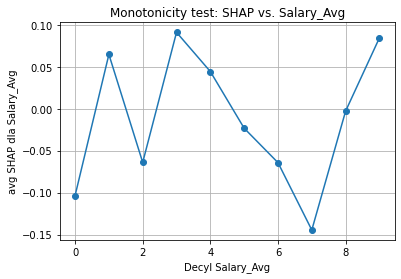

In [ ]:
df_monotonic = X_test.copy() # Create a copy of the test set
df_monotonic['SHAP_Salary'] = shap_values_rf[:, X.columns.get_loc('Salary_Avg')]  # Add the SHAP values for the feature 'Salary_Avg' as a new column

df_monotonic['Salary_Decile'] = pd.qcut(df_monotonic['Salary_Avg'], 10, labels=False)  # Create deciles for the 'Salary_Avg' feature to group salaries into 10 equally sized bins

trend = df_monotonic.groupby('Salary_Decile')['SHAP_Salary'].mean().reset_index()  # Calculate the average SHAP value for each salary decile

rho, pval = spearmanr(trend['Salary_Decile'], trend['SHAP_Salary'])  # Compute Spearman correlation to measure monotonicity between salary level and SHAP value
print(f" Spearman ρ for Salary_Avg vs. SHAP(Salary_Avg): {rho:.3f} (p={pval:.4f})")

plt.plot(trend['Salary_Decile'], trend['SHAP_Salary'], marker='o')
plt.xlabel('Decyl Salary_Avg')
plt.ylabel('avg SHAP dla Salary_Avg')
plt.title('Monotonicity test: SHAP vs. Salary_Avg')
plt.grid(True)
plt.show()


Random Forest provides unstable and non-monotonic explanations for Salary_Avg.

Spearman ρ = 0.067, p = 0.8548:
ρ ≈ 0 → No monotonic relationship between Salary_Avg and its SHAP value.

p-value > 0.85 → Result is statistically insignificant. The pattern is random

Plot Interpretation:
The SHAP values fluctuate wildly across salary deciles.

No clear upward or downward trend — instead, it’s noisy and irregular.

Indicates Random Forest sees no consistent relationship between salary and the predicted class ("More Experienced").

📈 Spearman ρ for Salary_Avg vs. SHAP(Salary_Avg): -0.612 (p=0.0600)


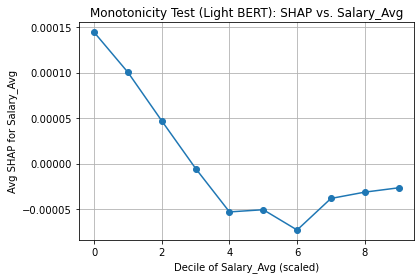

In [ ]:

#Recreate the deciled dataset
df_monotonic_bert = pd.DataFrame(X_shap_bert, columns=['Salary_Avg', 'Rating'])  # Match scaled column names
df_monotonic_bert['SHAP_Salary'] = shap_values_bert_class1[:, 0]  # SHAP for Salary_Avg (feature 0)

# Group Salary_Avg into deciles
df_monotonic_bert['Salary_Decile'] = pd.qcut(df_monotonic_bert['Salary_Avg'], 10, labels=False)

# Average SHAP value per decile
trend_bert = df_monotonic_bert.groupby('Salary_Decile')['SHAP_Salary'].mean().reset_index()

# Spearman correlation (monotonicity)
rho_bert, pval_bert = spearmanr(trend_bert['Salary_Decile'], trend_bert['SHAP_Salary'])
print(f"📈 Spearman ρ for Salary_Avg vs. SHAP(Salary_Avg): {rho_bert:.3f} (p={pval_bert:.4f})")

# Plot
plt.plot(trend_bert['Salary_Decile'], trend_bert['SHAP_Salary'], marker='o')
plt.xlabel('Decile of Salary_Avg (scaled)')
plt.ylabel('Avg SHAP for Salary_Avg')
plt.title('Monotonicity Test (Light BERT): SHAP vs. Salary_Avg')
plt.grid(True)
plt.show()

Spearman ρ = –0.612, p = 0.0600: Moderate negative correlation between Salary_Avg and its SHAP value.
As salary increases, the SHAP importance tends to decrease — higher salaries contribute less positively (or more negatively) to the prediction of being "More Experienced."
p-value ~ 0.06 → borderline significant. There's some evidence of monotonicity, but it’s not statistically strong at the 0.05 threshold.

Plot: Clear downward trend in SHAP values from lower to higher salary deciles (left to right). Flattening and slight rebound in last deciles → SHAP values stop decreasing and may rise again for the highest salaries.

Comparison:

Light BERT is clearly more explainable:
Its SHAP values are accurate, stable, and show a monotonic relationship with salary.
Random Forest, while still valid, offers noisy and inconsistent explanations for the same feature.